In [97]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'

import load_nmeg as ld
import transform_nmeg as tr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
# Read Laura's data in

path = "/home/greg/Desktop/FINAL_DATABASIS/"
pjc_laura = pd.read_csv( path + "PJC_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_laura = pd.read_csv( path + "PJG_ECDaily_Transp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')
pjc_lauraftp = pd.read_csv( path + "PJC_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date'  )
pjg_lauraftp = pd.read_csv( path + "PJG_ECDaily_Transp_ftp.CSV", header=0,
                        parse_dates={ 'Date': [0, 1, 2] },
                        na_values='NaN', index_col='Date')

In [99]:

def sum_30min_et( df, t_air ) :
    """
    # THIS IS THE OLD METHOD
    Convert 30min latent heat flux to ET ( W/m^2 to mm/s ) and sum (integrate) 
    for each 30min period. 

    see http://bwc.berkeley.edu/Amflux/equations/Gretchen-latent-heat-flux.htm

    Should we sum this for the entire day or for only daytime hours?
    """

    df_int = df.copy()
    # Define the lambda parameter
    lmbda = ( 2.501 - 0.00236 * t_air ) * 1000
    # For each input column create a new header and convert values to ET
    for i, cname in enumerate( df.columns ) :
        export_cname = 'ET_mm_int_' + str( i )
        et_mms = ( 1 / ( lmbda * 1000 )) * df_int[ cname ]
        et_mm_int = et_mms * 1800
        df_int[ export_cname ] = et_mm_int

    return df_int[ export_cname ]

def resample_30min_ET_daymethod( df, freq='1D', le_col='LE_F', tair_col='TA_F', sw_col='SW_IN_F'):
    """
    # THIS IS THE NEW METHOD
    Integrate 30 minute ET data into a daily (or longer) frequency file. Latent heat    
    flux is converted to ET using daily mean LE from DAYTIME ONLY values.
    
    Args:
        df          : pandas DataFrame object (usually derived from AF file)
        freq        : frequency to resample to (default daily)
        le_col      : latent heat flux header name(s)
        tair_col    : air temperature header (string) used for ET calculation

    Return:
        df_le_daily   : pandas dataframe with ET data at new frequency

    """

    # Make a subset dataframe with LE and Tair
    df_le = df[[le_col, tair_col]].copy()
    # Make a column to indicate daytime periods
    df_le['daytime_obs'] = 0
    # Mark daytime observations and nightime LE/Tair to NaN
    daytest = df['SW_IN_F'] > 5
    df_le.loc[daytest, 'daytime_obs'] = 1
    df_le.loc[~daytest, [le_col,tair_col]] = np.nan

    # Calculate mean daily LE and Tair
    df_le_daily = df_le.resample( freq, how='mean')
    # Sum the number of daytime observations
    df_le_daily['daytime_obs'] = df_le.daytime_obs.resample( freq, how='sum')
    # Calculate the lambda value for each day
    df_le_daily['lmbda'] = ( 2.501 - 0.00236 * df_le_daily[tair_col] ) * 1000
    # Calculate ET ( meand daily LE / (1000*lambda) * # daytime seconds
    df_le_daily['et_day'] = ( ( 1 / ( df_le_daily.lmbda * 1000 )) * df_le_daily[ le_col ] * 
                               (df_le_daily.daytime_obs * 1800) )
    

    return df_le_daily

In [100]:
# Get Greg's data
# Years to load
start = 2009
end = 2013
# Sites to load
sites = ['Mpj', 'Mpg']

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpj_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Mpg_2013_gapfilled.txt


In [101]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

et_daymethod = { x : 
                resample_30min_ET_daymethod( hourly[x], freq='1D',
                                le_col='LE_F', tair_col='TA_F', sw_col='SW_IN_F' ) 
                for x in hourly.keys() }

# Convert these to a pandas panel
d = pd.Panel(daily)
et_dly = pd.Panel(et_daymethod)

#Export for laura
et_dly.Mpj.to_csv('processed_data/Mpj_daily_daytime_ET.csv')
et_dly.Mpg.to_csv('processed_data/Mpg_daily_daytime_ET.csv')

## Compare ET and P

In [102]:
# ET
df_ET = pd.DataFrame( index = np.asarray(range(start, end)))
df_ET_day = pd.DataFrame( index = np.asarray(range(start, end)))
df_P = pd.DataFrame( index = np.asarray(range(start, end)))

gby = d.Mpg.ET_mm_int_0.groupby(d.Mpg.index.year)
df_ET['Girdle ET(Greg)'] = gby.sum()
gby = d.Mpj.ET_mm_int_0.groupby(d.Mpj.index.year)
df_ET['Control ET(Greg)'] = gby.sum()
gby = pjg_laura.ET.groupby(pjg_laura.index.year)
df_ET['Girdle ET(Laura)'] = gby.sum()
gby = pjc_laura.ET.groupby(pjc_laura.index.year)
df_ET['Control ET(Laura)'] = gby.sum()

gby = et_dly.Mpg.et_day.groupby(d.Mpg.index.year)
df_ET_day['Girdle et_day(Greg)'] = gby.sum()
gby = et_dly.Mpj.et_day.groupby(d.Mpj.index.year)
df_ET_day['Control et_day(Greg)'] = gby.sum()
gby = pjg_laura.ET_Dayt.groupby(pjg_laura.index.year)
df_ET_day['Girdle ET_Dayt(Laura)'] = gby.sum()
gby = pjc_laura.ET_Dayt.groupby(pjc_laura.index.year)
df_ET_day['Control ET_Dayt(Laura)'] = gby.sum()

In [103]:
# This is summed raw ET numbers from Laura and Greg's data
df_ET

,Girdle ET(Greg),Control ET(Greg),Girdle ET(Laura),Control ET(Laura)
2009,366.754755,318.538314,374.166232,320.486766
2010,392.736322,408.280116,392.321345,404.886621
2011,256.508241,279.035578,256.110038,281.656078
2012,264.206906,301.481257,251.740634,300.457563


In [104]:
# This is ET calculated on a daily basis from daytime LE/Tair values only (SW_IN > 5)
df_ET_day

,Girdle et_day(Greg),Control et_day(Greg),Girdle ET_Dayt(Laura),Control ET_Dayt(Laura)
2009,339.515282,302.850970,346.796318,307.329569
2010,374.125634,388.401445,374.948771,387.112575
2011,245.738976,268.618076,245.743733,271.108398
2012,248.098987,291.519802,233.097157,291.429758


In [105]:
# Precip
gby = d.Mpg.P_F.groupby(d.Mpg.index.year)
df_P['Girdle Precip (Greg)'] = gby.sum()
gby = d.Mpj.P_F.groupby(d.Mpj.index.year)
df_P['Control Precip(Greg)'] = gby.sum()
gby = pjg_laura.PRECIP.groupby(pjg_laura.index.year)
df_P['Girdle Precip(Laura)'] = gby.sum()
gby = pjc_laura.PRECIP.groupby(pjc_laura.index.year)
df_P['Control Precip(Laura)'] = gby.sum()

df_P

,Girdle Precip (Greg),Control Precip(Greg),Girdle Precip(Laura),Control Precip(Laura)
2009,322.93017,329.45052,297.942,329.200000
2010,347.98000,328.92627,347.980,328.926008
2011,255.77800,273.80000,255.778,273.600000
2012,157.24000,180.30000,151.892,165.500000


## Plot comparisons for control

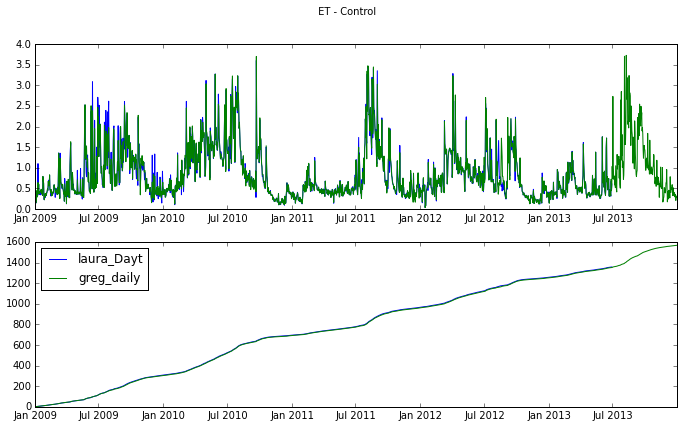

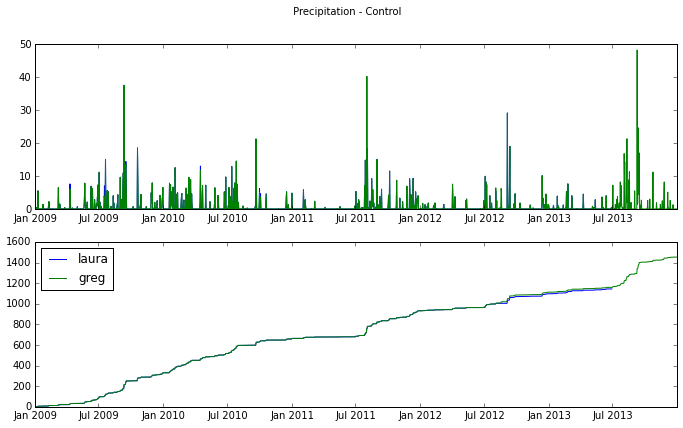

In [106]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.ET_Dayt)
#plt.plot(pjc_laura.index, pjc_laura.ET)
plt.plot(et_dly.Mpj.index, et_dly.Mpj.et_day)
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.ET_Dayt.cumsum())
#plt.plot(pjc_laura.index, pjc_laura.ET.cumsum())
plt.plot(et_dly.Mpj.index, et_dly.Mpj.et_day.cumsum())
#plt.plot(d.Mpj.index, d.Mpj.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Control')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjc_laura.index, pjc_laura.PRECIP)
plt.plot(d.Mpj.index, d.Mpj.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjc_laura.index, pjc_laura.PRECIP.cumsum())
plt.plot(d.Mpj.index, d.Mpj.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Control')
plt.show()

## Plot comparisons for girdle

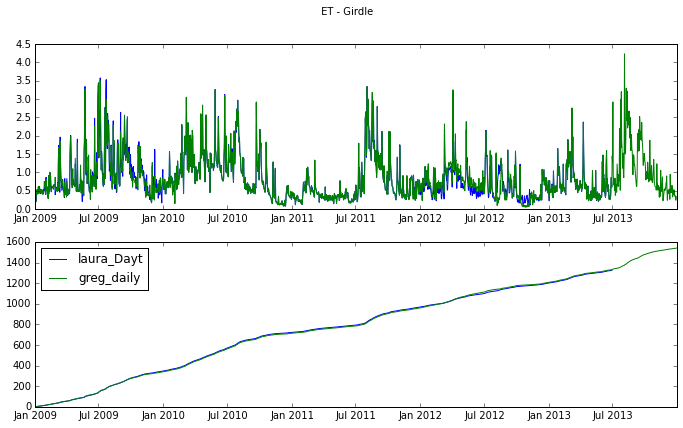

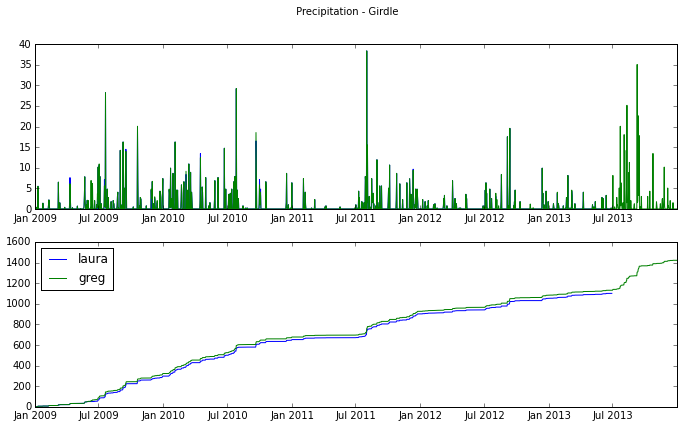

In [107]:
# ET
plt.figure(1, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.ET_Dayt)
#plt.plot(pjg_laura.index, pjg_laura.ET)
plt.plot(et_dly.Mpg.index, et_dly.Mpg.et_day)
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.ET_Dayt.cumsum())
#plt.plot(pjg_laura.index, pjg_laura.ET.cumsum())
plt.plot(et_dly.Mpg.index, et_dly.Mpg.et_day.cumsum())
#plt.plot(d.Mpg.index, d.Mpg.ET_mm_int_0.cumsum())
plt.legend(['laura_Dayt', 'greg_daily'], loc='upper left')
plt.suptitle(' ET - Girdle')
plt.show()

# Precip
plt.figure(2, figsize=( 11.5, 6.5 ))
ax1 = plt.subplot(2, 1, 1)
plt.plot(pjg_laura.index, pjg_laura.PRECIP)
plt.plot(d.Mpg.index, d.Mpg.P_F)
ax2 = plt.subplot(2, 1, 2)
plt.plot(pjg_laura.index, pjg_laura.PRECIP.cumsum())
plt.plot(d.Mpg.index, d.Mpg.P_F.cumsum())
plt.legend(['laura', 'greg'], loc='upper left')
plt.suptitle(' Precipitation - Girdle')
plt.show()